In [1]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from numpy import array
from scipy.stats import mode
from scipy.interpolate import interp1d

import pandas as pd
from pandas import read_csv
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import SimpleRNN
from keras.layers import Conv1D, MaxPooling1D, Dense, Input, Dropout, Flatten, BatchNormalization
from keras.layers import concatenate, Dropout
from keras.utils import to_categorical
from keras import optimizers
import seaborn as sns

In [2]:
df = read_csv('stock.csv')
df.head()

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
0,20210601,A060310,3S,166690,2890,2970,2885,2920
1,20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780
2,20210601,A006840,AK홀딩스,103691,35500,35600,34150,34400
3,20210601,A054620,APS,462544,14600,14950,13800,14950
4,20210601,A265520,AP시스템,131987,29150,29150,28800,29050


In [3]:
desired_stock_code="A001040"
df = df[df['종목코드'] == desired_stock_code]

In [4]:
df.head()

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
12,20210601,A001040,CJ,221664,115000,118000,114500,114500
2012,20210602,A001040,CJ,110030,115000,116500,113000,115500
4012,20210603,A001040,CJ,96992,116500,117000,114000,114000
6012,20210604,A001040,CJ,170692,113500,113500,110000,111000
8012,20210607,A001040,CJ,92000,112000,113000,110000,111500


In [5]:
df.shape

(494, 8)

In [6]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)

    return numerator / (denominator + 1e-7)

In [7]:
dfx = df[['시가', '고가', '저가', '종가', '거래량']]
dfx = MinMaxScaler(dfx)

dfy = dfx[['종가']]
dfx = dfx[['시가', '고가', '저가', '거래량']]

dfx

,시가,고가,저가,거래량
12,0.969512,1.000000,1.000000,0.081950
2012,0.969512,0.969199,0.968220,0.038085
4012,1.000000,0.979466,0.989407,0.032962
6012,0.939024,0.907598,0.904661,0.061921
8012,0.908537,0.897331,0.904661,0.031000
...,...,...,...,...
978012,0.467480,0.437372,0.466102,0.018366
980012,0.459350,0.447639,0.472458,0.029496
982012,0.467480,0.431211,0.451271,0.017653
984012,0.449187,0.431211,0.432203,0.025048


In [8]:
dfx.describe()

,시가,고가,저가,거래량
count,494.000000,494.000000,494.000000,494.000000
mean,0.414832,0.399160,0.409100,0.020933
std,0.220768,0.226374,0.225445,0.047686
min,0.000000,0.000000,0.000000,0.000000
25%,0.256098,0.234600,0.248411,0.008478
50%,0.342480,0.322382,0.338983,0.013851
75%,0.607724,0.601129,0.609640,0.024518
max,1.000000,1.000000,1.000000,1.000000


In [9]:
dfy.head()

,종가
12,0.979036
2012,1.000000
4012,0.968553
6012,0.905660
8012,0.916143


In [10]:
time_step = 40
step = 10

def create_dataset(X, y, time_step, step):
    Xs, ys = [], []

    for i in range(0, len(X) - time_step, step):
        v = X.iloc[i : (i + time_step)].values
        labels = y.iloc[i + time_step]

        Xs.append(v)
        ys.append(labels)

    return np.array(Xs), np.array(ys)

In [11]:
X, y = create_dataset(dfx, dfy, time_step, step)

X.shape

(46, 40, 4)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30, 40, 4), (16, 40, 4), (30, 1), (16, 1))

In [13]:

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=7, activation='relu', padding='same', input_shape=(n_timesteps, n_features)))
model.add(MaxPooling1D(2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', input_shape=(n_timesteps, n_features)))
model.add(MaxPooling1D(2))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same', input_shape=(n_timesteps, n_features)))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [14]:
from keras.optimizers import Adam

model.compile(loss='mse', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [15]:
# fit network
train_epochs = 300
history = model.fit(X_train, y_train, epochs=train_epochs, batch_size=64, verbose=True,  validation_split=0.2, shuffle=True)

Epoch 1/300
1/1 [==============================] - 7s 7s/step - loss: 0.0566 - accuracy: 0.0000e+00 - val_loss: 0.0578 - val_accuracy: 0.0000e+00
Epoch 2/300
1/1 [==============================] - 0s 166ms/step - loss: 0.0568 - accuracy: 0.0000e+00 - val_loss: 0.0569 - val_accuracy: 0.0000e+00
Epoch 3/300
1/1 [==============================] - 0s 172ms/step - loss: 0.0544 - accuracy: 0.0000e+00 - val_loss: 0.0567 - val_accuracy: 0.0000e+00
Epoch 4/300
1/1 [==============================] - 0s 161ms/step - loss: 0.0539 - accuracy: 0.0000e+00 - val_loss: 0.0567 - val_accuracy: 0.0000e+00
Epoch 5/300
1/1 [==============================] - 0s 149ms/step - loss: 0.0527 - accuracy: 0.0000e+00 - val_loss: 0.0562 - val_accuracy: 0.0000e+00
Epoch 6/300
1/1 [==============================] - 0s 168ms/step - loss: 0.0513 - accuracy: 0.0000e+00 - val_loss: 0.0560 - val_accuracy: 0.0000e+00
Epoch 7/300
1/1 [==============================] - 0s 177ms/step - loss: 0.0466 - accuracy: 0.0000e+00 - val_

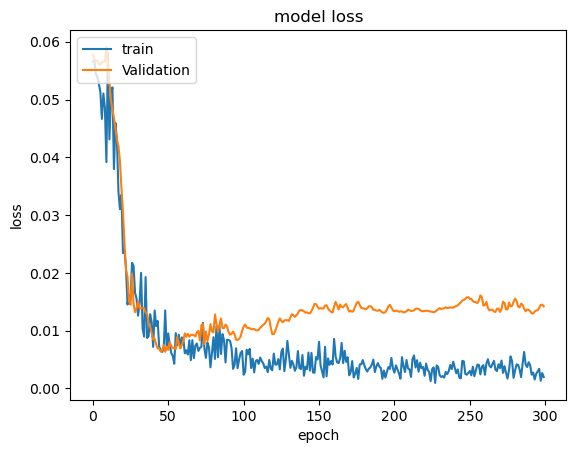

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [17]:
# evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=64, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(X_test)

Accuracy of the CNN model 0.0
1/1 [==============================] - 0s 363ms/step


In [18]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 66ms/step


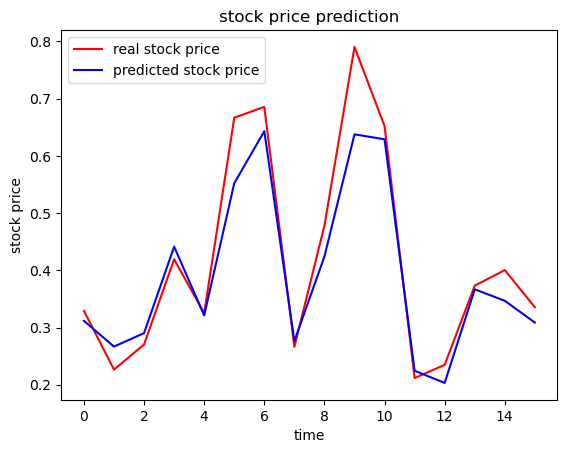

In [19]:
y_pred.shape

plt.plot(y_test, color='red', label='real stock price')
plt.plot(y_pred, color='blue', label='predicted stock price')
plt.title('stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()